# Сборка нужных функций


In [1]:
import pandas as pd

In [2]:
import networkx as nx
import numpy as np

In [3]:
import igraph as ig

In [4]:
from networkx.algorithms import isomorphism

### Слияние станций

In [5]:
def un_vect(a):
    vd={}
    c=0
    for e in a:
        v1=''.join([i for i in e[0] if not i.isdigit()])
        v2=''.join([i for i in e[1] if not i.isdigit()])
        if(v1 != v2):
            if(e[0] in vd):
                vd[e[1]]=vd[e[0]]
            elif(e[1] in vd):
                vd[e[0]]=vd[e[1]]
            else:
                vd[e[0]]="TT"+str(c)
                vd[e[1]]="TT"+str(c)
                c+=1
    return vd

### Создание карты цветов для станций

In [6]:
cl = ['red', 'green', 'blue', 'yellow', 'brown', 'gray', 'pink', 'darkblue', 'cyan', 'purple', 'seagreen', 'orange', 'bisque', 'lime', 'darkmagenta']

def set_colors(tm):
    cmn={}
    ln=[]
    for v in list(tm.nodes):
        ln.append(''.join([i for i in v if not i.isdigit()]))
    k=list(set(ln))
    for i in range(len(k)):
        cmn[k[i]]=cl[i]
    return cmn

### Кодирование станций

In [7]:
def enc_stations(b): 
    sd={}
    ln=[]
    n=len(b["Line"].unique())
    c=[1]*n
    le={}
    for i in b["Line"].unique():
        le[i]=len(le)
    for i in range(n):
        ln.append(chr(ord("A")+i))
    for j in range(len(b.values)):
        i=b.values[j]
        if i[0] not in sd:
            l=le[i[2]]
            sd[i[0]]=ln[l] + str(c[l]).zfill(2)
            c[l]+=1
        if(i[1] not in sd and ((j+1 < len(b.values) and b.values[j+1][2]!=i[2]) or j+1 == len(b.values))):
            l=le[i[2]]
            sd[i[1]]=ln[l] + str(c[l]).zfill(2)
            c[l]+=1
    return sd

### Конвертация

In [8]:
def networkx_to_igraph(G):
    mapping = dict(zip(G.nodes(),range(G.number_of_nodes())))
    reverse_mapping = dict(zip(range(G.number_of_nodes()),G.nodes()))
    G = nx.relabel_nodes(G,mapping)
    G_ig = ig.Graph(len(G), list(zip(*list(zip(*nx.to_edgelist(G)))[:2])))
    return G_ig, reverse_mapping 

## Проверка необходимых условий изоморфизма

In [9]:
def check_graph_properties(G1, G2):
    if(len(G1)==len(G2) and len(G1.edges)==len(G2.edges)):
        if sorted(dict(G1.degree).values())==sorted(dict(G2.degree).values()):
            if(sorted(np.linalg.eig(nx.adjacency_matrix(G1).todense())[0]) == sorted(np.linalg.eig(nx.adjacency_matrix(G2).todense())[0])):
                return True
            else:
                return False
        
        else:
            return False
    else:
        return False

## Удаление случайных вершин в большем графе

In [10]:
import random
def cut_down(tm, vm):
    bb=tm.copy()
    while(len(tm)>len(vm) and not nx.is_connected(bb)):
        bb=tm.copy()
        nl=bb.nodes()
        n=len(bb)-len(vm)
        rnl=random.sample(nl, n)
        bb.remove_nodes_from(rnl)
    return bb

In [11]:
def check_random_iso(tm, vm, i=1):
    r=cut_down(tm, vm)
    GM = isomorphism.GraphMatcher(r,vm)
    while i>0 and not GM.is_isomorphic():
        r=cut_down(tm, vm)
        GM = isomorphism.GraphMatcher(r,vm)
        i-=1
    return GM.is_isomorphic(), r

# ТОКИО

In [12]:
a=pd.read_json("stations.json", orient='index')

In [13]:
tmel=[]
for i in range(len(a['connections'])):
    for j in a['connections'][i]:
        tmel.append([a.index[i], j['target_id']])

In [14]:
b=un_vect(tmel) #merge stations with walk connection (transfers)
for e in tmel:
    for v in range(len(e)):
        if e[v] in b:
            e[v]=b[e[v]]

In [15]:
tm=nx.Graph()
tm.add_edges_from(tmel)
tm.remove_edges_from(tm.selfloop_edges())

In [16]:
cmn = set_colors(tm)
cm=[]
for v in list(tm.nodes):
    nn=''.join([i for i in v if not i.isdigit()])
    cm.append(cmn[nn])

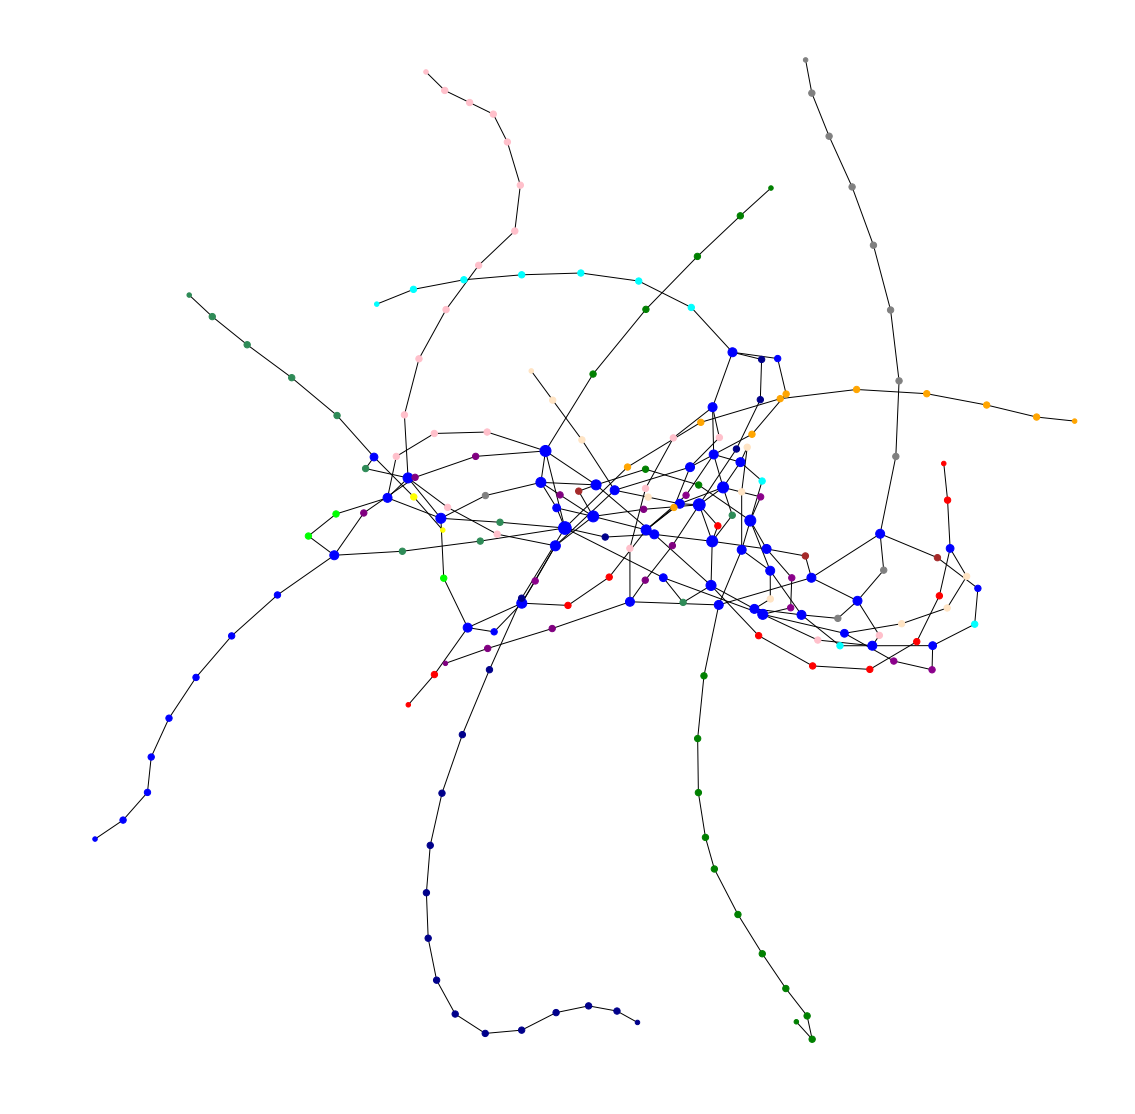

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
nx.draw_spring(tm, node_size=[i[1]*20 for i in list(tm.degree)], node_color=cm)
plt.show()

# Вена

In [19]:
b = pd.read_csv("Vienna.csv", sep=';')

In [20]:
vmel=b[["Start", "Stop"]].values.tolist()
sd=enc_stations(b) # encode stations and lines for processing
for i in vmel:
    for j in range(len(i)):
        i[j]=sd[i[j]]


In [21]:
c=un_vect(vmel) #merge stations with walk connection (transfers)
for e in vmel:
    for v in range(len(e)):
        if e[v] in c:
            e[v]=c[e[v]]

In [22]:
vm=nx.Graph()
vm.add_edges_from(vmel)
vm.remove_edges_from(vm.selfloop_edges())

In [23]:
cmn = set_colors(vm)
cm=[]
for v in list(vm.nodes):
    nn=''.join([i for i in v if not i.isdigit()])
    cm.append(cmn[nn])

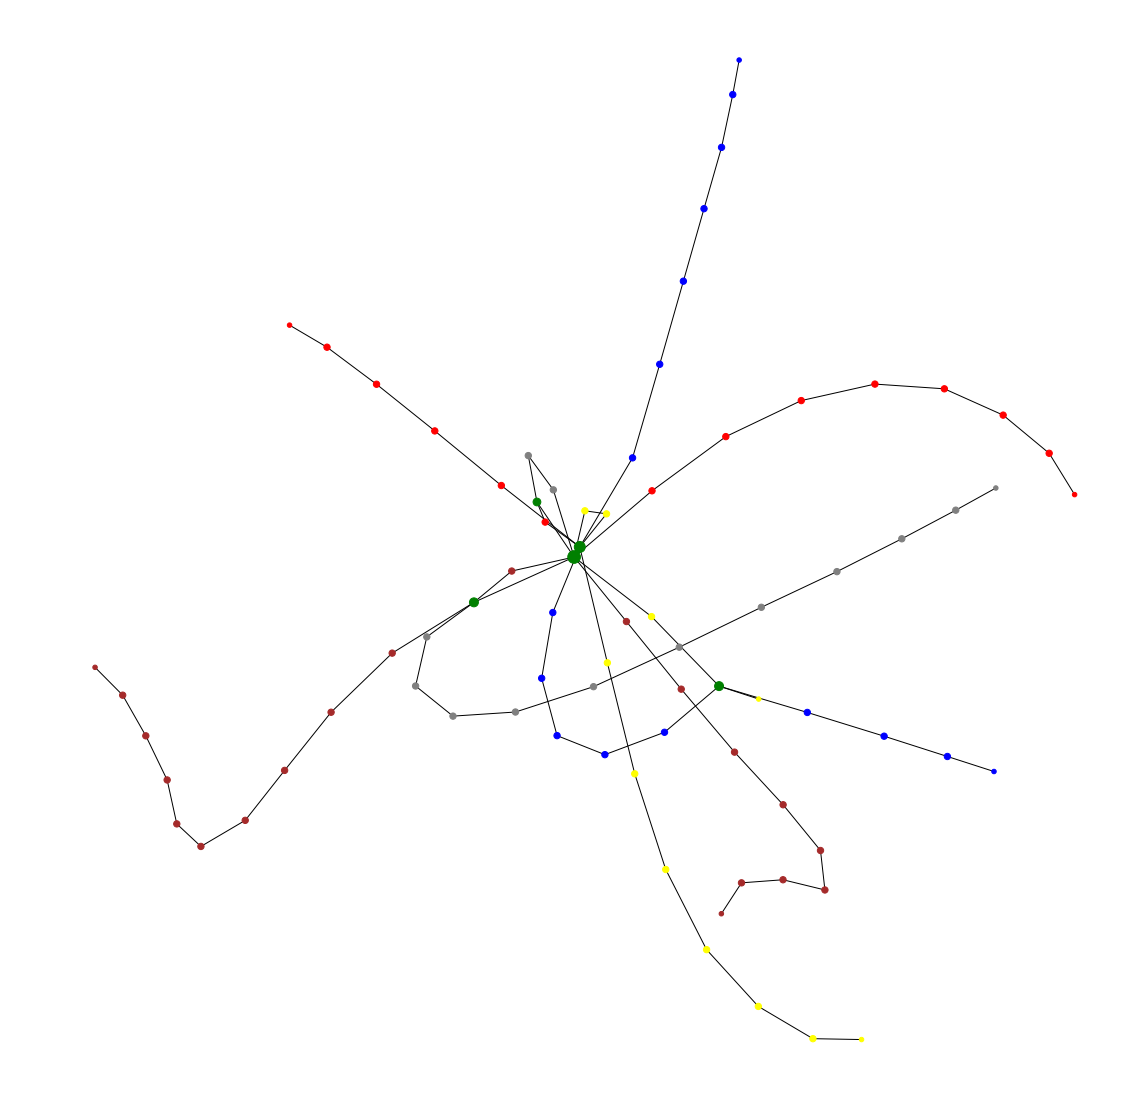

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
nx.draw_spring(vm, node_size=[i[1]*20 for i in list(vm.degree)], node_color=cm, node_aplha=0.5)
plt.show()

# Пхеньян

In [25]:
b = pd.read_csv("pyongyang.csv", sep=';')

In [26]:
pmel=b.values.tolist()
c=un_vect(pmel) #merge stations with walk connection (transfers)
for e in pmel:
    for v in range(len(e)):
        if e[v] in c:
            e[v]=c[e[v]]
pm=nx.Graph()
pm.add_edges_from(pmel)
pm.remove_edges_from(pm.selfloop_edges())

In [27]:
cmn = set_colors(pm)
cm=[]
for v in list(pm.nodes):
    nn=''.join([i for i in v if not i.isdigit()])
    cm.append(cmn[nn])

In [28]:
pm.edges

EdgeView([('A01', 'TT0'), ('TT0', 'A03'), ('TT0', 'B03'), ('TT0', 'B05'), ('A03', 'A04'), ('A04', 'A05'), ('A05', 'A06'), ('A06', 'A07'), ('A07', 'A08'), ('B01', 'B02'), ('B02', 'B03'), ('B05', 'B06'), ('B06', 'B07'), ('B07', 'B08'), ('B08', 'B09')])

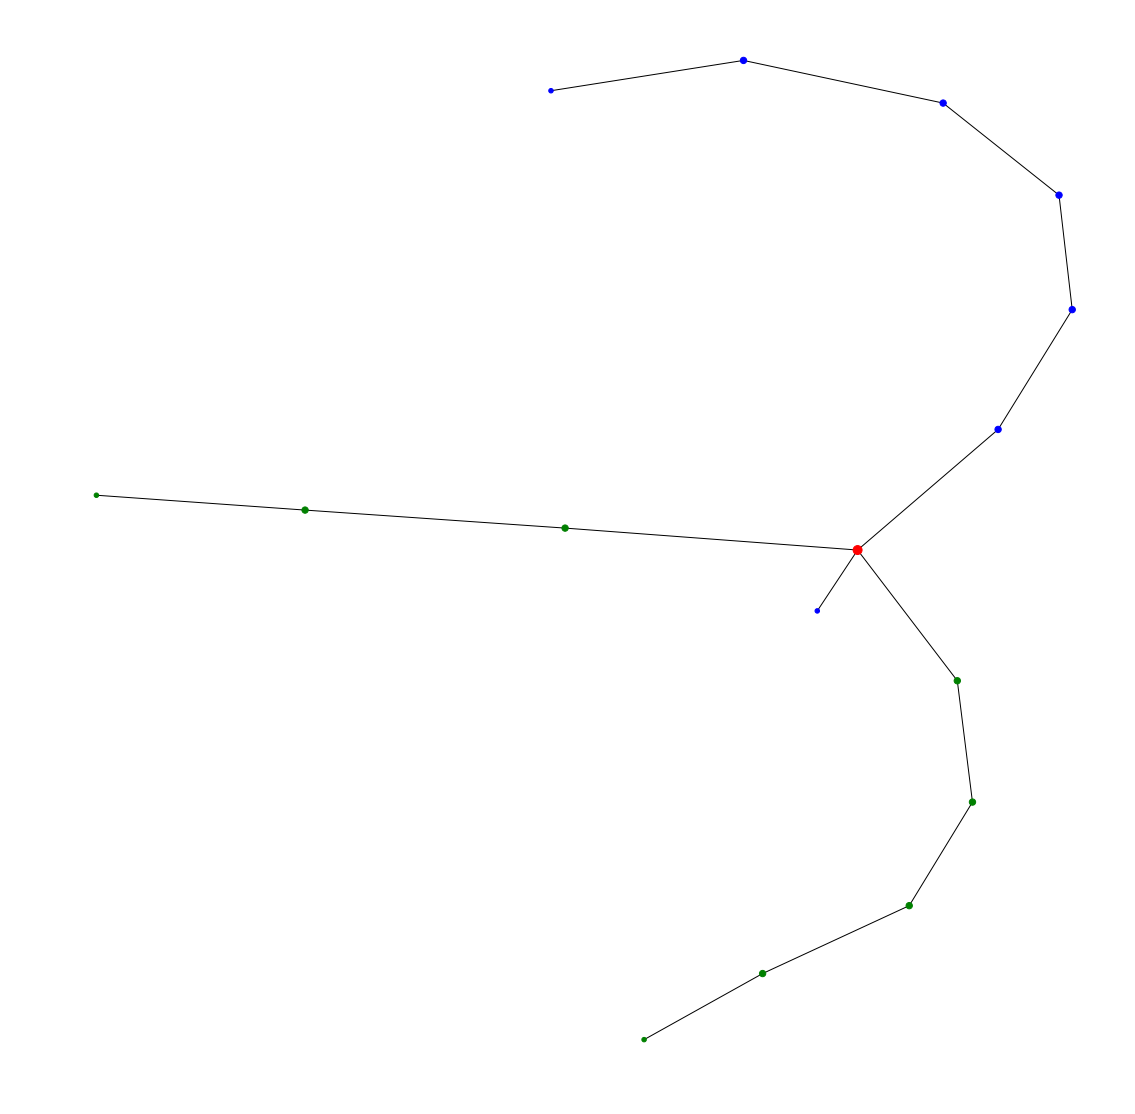

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
nx.draw_spring(pm, node_size=[i[1]*20 for i in list(pm.degree)], node_color=cm)
plt.show()

# Проверка больших графов на изоморфизм

In [30]:
itm,_=networkx_to_igraph(tm)
ivm,_=networkx_to_igraph(vm)
ipm,_=networkx_to_igraph(pm)

### Проверка случайного подграфа

In [31]:
check_random_iso(tm, vm) # VF2

(False, <networkx.classes.graph.Graph at 0x175d93bcbe0>)

### VF2

In [32]:
GM = isomorphism.GraphMatcher(tm,vm)
GM.subgraph_is_isomorphic()

False

### LAD

In [33]:
itm.subisomorphic_lad(ivm)

False

### Проверка необходимых условий

In [34]:
check_graph_properties(tm, vm)

False

In [35]:
check_graph_properties(cut_down(tm, vm), vm)

False

# Поиск изоморфного подграфа

Проверяем подграфы Вены

In [36]:
tg=vm
GM = isomorphism.GraphMatcher(tg,pm)
if(GM.subgraph_is_isomorphic()):
    r=next(GM.subgraph_isomorphisms_iter())

In [37]:
cm=['lightgrey']*len(tg)
nl=list(tg.nodes)
for i in range(len(tg)):
    if(nl[i] in r):
        cm[i]='red'

In [38]:
sel=[]
for i in tg.edges():
    if(i[0] in r and i[1] in r):
        sel.append(i)

## Сам подграф

In [39]:
sel

[('A09', 'TT1'),
 ('TT1', 'TT0'),
 ('TT1', 'C12'),
 ('TT1', 'D10'),
 ('TT0', 'B11'),
 ('B08', 'B09'),
 ('B09', 'B10'),
 ('B10', 'B11'),
 ('C03', 'C04'),
 ('C04', 'C05'),
 ('C05', 'TT3'),
 ('TT3', 'D09'),
 ('C12', 'C13'),
 ('C13', 'C14'),
 ('D09', 'D10')]

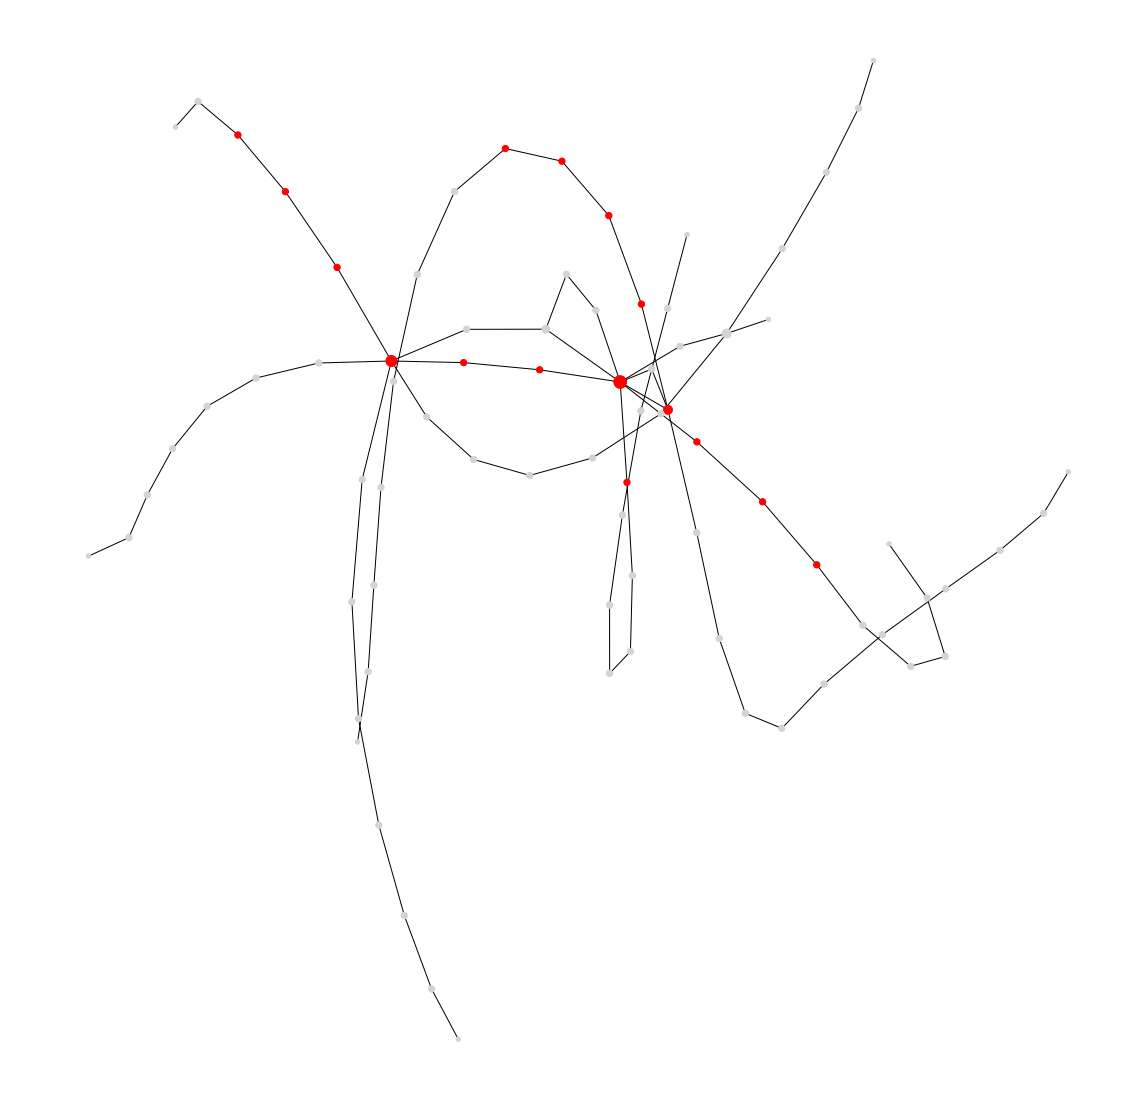

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
nx.draw_spring(tg, node_size=[i[1]*20 for i in list(tg.degree)], node_color=cm)
plt.show()

# Алгоритм Ульмана

http://algowiki-project.org/ru/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%A3%D0%BB%D1%8C%D0%BC%D0%B0%D0%BD%D0%B0

In [41]:
import sys, collections, copy, re
from networkx.classes.graph import Graph as NXGraph

class uGraph(NXGraph):
    def __init__(self):
        super().__init__()

    def from_existing(self, g):
        try:
            self.add_edges_from(g.edges)
            self.num_nodes = len(self.nodes())
            self.num_edges = len(self.edges())
            self.nodelist = sorted(self.nodes())
            self.node_ids = pd.Series(self.nodelist, index=range(self.num_nodes))
            self.node_id2idx = pd.Series(range(self.num_nodes), index=self.nodelist)
            self.node_labels = pd.Series([0 for nid in self.nodelist], index=self.nodelist)
            self.node_degrees = pd.Series([self.degree(nid) for nid in self.nodelist], index=self.nodelist)
            tmp = np.zeros((self.num_nodes, self.num_nodes))
            self.edge_labels = pd.DataFrame(tmp)
            self.edge_labels.index = self.nodelist
            self.edge_labels.columns = self.nodelist
            return True
        except():
            return False

    def get_adjacency_matrix(self):
        a = nx.adjacency_matrix(self, nodelist=self.nodelist)
        self.adj_mat = a.toarray()
        return self.adj_mat

class UllmanAlgorithm(object):
    def __init__(self, *args, **kwargs):
        super().__init__()

    def _init_params(self, g, q, display_M=False, display_mapping=True, max_num_iso=1):
        self.q = q # query graph
        self.g = g # target graph
        self.A = q.get_adjacency_matrix()
        self.B = g.get_adjacency_matrix()
        self.display_M = display_M
        self.display_mapping = display_mapping
        self.max_num_iso = max_num_iso
        self.done = 0 >= max_num_iso
        for attr in ['num_nodes', 'num_edges']:
            setattr(self, attr + '_q', getattr(q, attr))
            setattr(self, attr + '_g', getattr(g, attr))

        self._construct_M()
        self.avail_g = np.ones(self.num_nodes_g) # if one node in g is not used/mapped.
        self.M_iso = list()
        self.mappings = list()

    def _construct_M(self):
        self.M = np.logical_and(self.q.node_labels.values[:, None] == self.g.node_labels.values,
            self.q.node_degrees.values[:, None] <= self.g.node_degrees.values)

        self.M = self.M.astype(int)
        self._refine_M(check_elabel=True)

    def _refine_M(self, max_iter=float('inf'), check_elabel=False):
        if check_elabel:
            el_g = self.g.edge_labels.values
            el_q = self.q.edge_labels.values
        changed = True
        num_iter = 0
        while changed and num_iter < max_iter:
            changed = False
            num_iter += 1
            for i in range(self.num_nodes_q):
                for j in range(self.num_nodes_g):
                    if check_elabel:
                        flag = self.M[i, j] > 0 and (self.A[i, :] > (self.M * (el_q[:, i][:, None] == el_g[j, :]) * self.B[j, :]).sum(axis=1)).any()
                    else:
                        flag = self.M[i, j] > 0 and (self.A[i, :] > self.M.dot(self.B.T[:, j])).any()
                    if flag:
                        self.M[i, j] = 0
                        changed = True

    def _check_isomorphic(self):
        C = self.M.dot((self.M.dot(self.B)).T)
        isomorphic = (self.A <= C).all()
        if isomorphic:
            self.M_iso.append(copy.deepcopy(self.M))
            self.mappings.append(self._get_mapping(-1))
            self.done = len(self.mappings) >= self.max_num_iso
        return isomorphic

    def _get_mapping(self, M_idx=None):
        if M_idx == None:
            res = list()
            for M_idx in range(len(self.M_iso)):
                res.append(self._get_mapping(M_idx))
            return res
        elif M_idx >= len(self.M_iso):
            return None
        M = self.M_iso[M_idx]
        I, J = np.where(M == 1)
        return zip(list(I), list(J))

    def _dfs(self, depth=0):
        if self.done:
            return
        if depth >= self.num_nodes_q:
            self._check_isomorphic()
            return
        row = copy.deepcopy(self.M[depth, :])
        if (row * self.avail_g).sum() == 0:
            return
        self.M[depth, :] = 0
        for j in range(self.num_nodes_g):
            if row[j] == 1 and self.avail_g[j] == 1:
                self.M[depth, j] = 1
                self.avail_g[j] = 0
                self._dfs(depth + 1)
                self.avail_g[j] = 1
                self.M[depth, j] = 0
                if self.done:
                    break
        self.M[depth, :] = row

    def run(self, g, q, display_M=False, display_mapping=True, max_num_iso=1):
        self._init_params(g, q, display_M=display_M, display_mapping=display_mapping, max_num_iso=max_num_iso)
        self._dfs(depth=0)

    def has_iso(self, g, q, display_M=False, display_mapping=True):
        self.run(g, q, display_M=display_M, display_mapping=display_mapping, max_num_iso=1)
        return len(self.mappings) > 0

In [42]:
def check_uiso(g1, g2):
    tvg=uGraph()
    tvg.from_existing(g1)
    tpg=uGraph()
    tpg.from_existing(g2)
    ua=UllmanAlgorithm()
    return ua.has_iso(tvg, tpg)


## Check if algorithm is correct

Ловушка для необходимого условия

In [43]:
g1=nx.Graph()
g2=nx.Graph()
g1.add_edges_from([(1,5),(2,3),(2,4),(1,2),(5,3)])
g2.add_edges_from([(1,5),(2,3),(3,4),(1,2),(5,2)])

In [44]:
check_uiso(g1, g2)

False

Очевидный пример изоморфизма

In [45]:
g1=nx.path_graph(4)
g2=nx.path_graph(4)

In [46]:
check_uiso(g1, g2)

True

## Test it

### Проверим большой и средний графы на изоморфизм

In [47]:
r=cut_down(tm, vm)

In [48]:
check_uiso(r, vm)

False

### Попробуем найти подграф (не стоит)

In [ ]:
check_uiso(vm, pm)